# Einleitung
Mit diesem Kernal wird versucht ein Clustering zwischen den Meteo und den Ertragsdaten zu erstellen.

## Hypothesen
Die folgenden Hypothesen sollen druch die Daten bewiesen werden.

1. Aus den gegebenen Meteodaten (Regen, Sonnenschein, Lufttemperatur, Globalstrahlung) kann der PV Ertrag ermittelt werden.
2. Gibt es einen Zusammenhang zwischen Regen und PV Ertragsdaten am Kommenden Tag? 

# Vorbereitung
Importieren der benötigten Bibliotheken
## Python Bibliotheken importieren

In [1]:
from impala.dbapi import connect 
from impala.util import as_pandas
import pandas as pd # For Data Handling
import numpy as np  # data processing, CSV file I/O (e.g. pd.read_csv)
import math as mt
import datetime as dt # To convert timestamp data
import matplotlib   #for plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
matplotlib.style.use('ggplot')
%matplotlib inline

## Daten aus HDFS Laden und bereinigen

### Wetterdaten von Einsiedeln

In [2]:
conn = connect(host='172.16.10.102', port=21050)
cur = conn.cursor()
cur.execute('SELECT * FROM meteo_einsiedeln order by time')
dfm = as_pandas(cur)
cur.close()
conn.close()
dfm.head(2)

station          time uto200s0 tre200s0 hto000s0 gre000z0 rre150z0 sre000z0
0     EIN  201201010000        -        -        -        -        -        -
1     EIN  201201010010        -        -        -        -        -        -

In [3]:
# Umwandeln des Strings in datetime format
dfm['timestamp'] = pd.to_datetime(dfm['time'],format='%Y%m%d%H%M')
# Umwandeln der datenobjekte als String mit '-' in numerische Zahlen
dfm['luftfeuchtigkeit'] = pd.to_numeric(dfm['uto200s0'], errors='coerce')
dfm['lufttemperatur'] = pd.to_numeric(dfm['tre200s0'], errors='coerce')
dfm['gesamtschneehöhe'] = pd.to_numeric(dfm['hto000s0'], errors='coerce')
dfm['globalstrahlung'] = pd.to_numeric(dfm['gre000z0'], errors='coerce')/1000
dfm['niederschlag'] = pd.to_numeric(dfm['rre150z0'], errors='coerce')
dfm['sonnenscheindauer'] = pd.to_numeric(dfm['sre000z0'], errors='coerce')

# lösche alle nicht benötigten Spalten
dfm.drop(['time','station','uto200s0','tre200s0','hto000s0','gre000z0','rre150z0','sre000z0'], inplace=True, axis=1)

In [4]:
dfm.head(2)

timestamp  luftfeuchtigkeit  lufttemperatur  gesamtschneehöhe  \
0 2012-01-01 00:00:00               NaN             NaN               NaN   
1 2012-01-01 00:10:00               NaN             NaN               NaN   

   globalstrahlung  niederschlag  sonnenscheindauer  
0              NaN           NaN                NaN  
1              NaN           NaN                NaN

In [5]:
# Remove samples with Globalstrahlung = 0
dfm = dfm.drop(dfm[dfm.globalstrahlung == 0].index)

In [6]:
dfm.describe()

luftfeuchtigkeit  lufttemperatur  gesamtschneehöhe  globalstrahlung  \
count     154944.000000   154946.000000       1468.000000    155401.000000   
mean           7.793163       10.366119          3.532016         0.279409   
std            3.087270        7.926621          9.623998         0.263157   
min            0.600000      -23.300000          0.000000         0.001000   
25%            5.200000        4.300000          0.000000         0.062000   
50%            7.600000       10.900000          0.000000         0.191000   
75%           10.100000       16.000000          0.000000         0.433000   
max           17.800000       31.100000         62.000000         1.371000   

        niederschlag  sonnenscheindauer  
count  155286.000000      154769.000000  
mean        0.025309           4.075500  
std         0.145914           4.790304  
min         0.000000           0.000000  
25%         0.000000           0.000000  
50%         0.000000           0.000000  
75%         0.000000          10.000000  
max        13.300000          10.000000

### PV Ertragsdaten von Birchli

In [8]:
conn = connect(host='172.16.10.102', port=21050)
cur = conn.cursor()
cur.execute('SELECT * FROM birchli_roh order by `timestamp`')
dfb = as_pandas(cur)
cur.close()
conn.close()
dfb.head(2)

id           timestamp  yield_1  yield_2  yield_tot
0   0 2010-11-30 00:00:00      0.0      NaN        0.0
1   1 2010-11-30 00:10:00      0.0      NaN        0.0

In [9]:
# Fehlerhafte Werte (grösser als 8 kW) entfernen
dfb = dfb.drop(dfb[dfb.yield_tot>8].index)
dfb['ertrag_modul1'] = dfb.yield_1
dfb = dfb.set_index('timestamp')

In [10]:
dfb.head(2)

id  yield_1  yield_2  yield_tot  ertrag_modul1
timestamp                                                          
2010-11-30 00:00:00   0      0.0      NaN        0.0            0.0
2010-11-30 00:10:00   1      0.0      NaN        0.0            0.0

In [11]:
dfb.describe()

id        yield_1        yield_2      yield_tot  \
count  342717.000000  342717.000000  341565.000000  342717.000000   
mean   171359.014082       0.335929       0.166697       0.502066   
std     98935.046183       0.636319       0.329454       0.947222   
min         0.000000       0.000000       0.000000       0.000000   
25%     85679.000000       0.000000       0.000000       0.000000   
50%    171359.000000       0.000000       0.000000       0.000000   
75%    257039.000000       0.318000       0.138000       0.492000   
max    342719.000000       2.898000       2.232000       4.890000   

       ertrag_modul1  
count  342717.000000  
mean        0.335929  
std         0.636319  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.318000  
max         2.898000

### Was passierte am 25.03.17 - 25.5.17 mit dem Modul2?
Wie es scheint hatte die Anlage zu diesem Zeitpunkt issues. wie es scheint können wir daraus nicht mit den yield_total weiterfahren sondern müssen nur das Modul1 berücksichtigen. Ansonsten verfelscht dieser Effekt die Performance Ratio!

In [12]:
# Careful this plot takes a while to render
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #need to use plotly offline

# Sub Datafrem eines bestimmter Zeitperiode Juni 2015
dfb_s = dfb[(dfb.index >= '2017-01-25') & (dfb.index <= '2017-06-25')]
    

data = Data([Bar(x=dfb_s.index, y=dfb_s.yield_tot, name='yield_tot'),
             Bar(x=dfb_s.index, y=dfb_s.yield_2, name='yield_2'),
             Bar(x=dfb_s.index, y=dfb_s.yield_1, name='yield_1')])
             
iplot(Figure(data=data, layout= Layout(title='PV Ertrag von Birchli')))

## 12:20 Analyse
Idee: Werte beim höchsten Sonnenstand ca. 12:20 verwenden und diese Dann über die Jahre vergleichen

Reduzieren der Datensätze auf die 12:20 Uhr und zusammenführen der Daten

In [15]:
# lösche alle nicht benötigten Spalten
dfb.drop(['id','yield_1','yield_2','yield_tot'], inplace=True, axis=1)
dfbp = dfb.at_time("12:20")
dfbp.head(2)

ertrag_modul1
timestamp                         
2010-11-30 12:20:00            0.0
2010-12-01 12:20:00            0.0

In [156]:
dfmp = dfm.set_index('timestamp')
dfmp = dfmp.at_time("12:20")
dfmp.head(2)

luftfeuchtigkeit  lufttemperatur  gesamtschneehöhe  \
timestamp                                                                 
2012-01-01 12:20:00               NaN             NaN               NaN   
2012-01-02 12:20:00               NaN             NaN               NaN   

                     globalstrahlung  niederschlag  sonnenscheindauer  
timestamp                                                              
2012-01-01 12:20:00              NaN           NaN                NaN  
2012-01-02 12:20:00              NaN           NaN                NaN

In [157]:
df = pd.concat([dfbp, dfmp], axis=1) # Combine dataframe birchli and meteo to dataframepeak
df['year'] = df.index.year # Add year colum to better filter
df['month'] = df.index.month # Add year colum to better filter
df['day'] = df.index.day # Add year colum to better filter
df.head()

ertrag_modul1  luftfeuchtigkeit  lufttemperatur  \
timestamp                                                              
2010-11-30 12:20:00            0.0               NaN             NaN   
2010-12-01 12:20:00            0.0               NaN             NaN   
2010-12-02 12:20:00            0.0               NaN             NaN   
2010-12-03 12:20:00            0.0               NaN             NaN   
2010-12-04 12:20:00            0.0               NaN             NaN   

                     gesamtschneehöhe  globalstrahlung  niederschlag  \
timestamp                                                              
2010-11-30 12:20:00               NaN              NaN           NaN   
2010-12-01 12:20:00               NaN              NaN           NaN   
2010-12-02 12:20:00               NaN              NaN           NaN   
2010-12-03 12:20:00               NaN              NaN           NaN   
2010-12-04 12:20:00               NaN              NaN           NaN   

                     sonnenscheindauer  year  month  day  
timestamp                                                 
2010-11-30 12:20:00                NaN  2010     11   30  
2010-12-01 12:20:00                NaN  2010     12    1  
2010-12-02 12:20:00                NaN  2010     12    2  
2010-12-03 12:20:00                NaN  2010     12    3  
2010-12-04 12:20:00                NaN  2010     12    4

#### Löschen felerhafter Datenpunkte

In [158]:
# Dropen der 0 Werte (Warum gibt es diese?? Gehen davon aus, dass dies eine Störung war)
df= df[df.ertrag_modul1 > 0]
df= df[df.globalstrahlung > 0]

In [160]:
# Berechne den median pro monat und fürde diesen monatswert jeder Zeile dazu
df_m = pd.DataFrame(df.groupby(by = ['year','month'])['globalstrahlung'].median())
df_m['global_median'] = df_m['globalstrahlung']
df_d['luft_median'] = df_d['lufttemperatur']
del df_m['globalstrahlung'], df_d['lufttemperatur']
df = df.join(df_m,on=['year','month']) # Combine dataframe birchli and meteo to dataframepeak
df = df.join(df_d,on=['year','month','day']) #
df.head()

KeyError: 'lufttemperatur'

#### Auswahl vergleichbaren Messwerte

In [140]:
# Nur Schöne Tage
dfp = df[df.sonnenscheindauer == 10]
# Annahme Monat Juni herschen ändliche Bedinngungen -> Somit Vergleichbar
dfp = dfp[(dfp.month == 6)]

# Um die Zellentemperatur vergleich bar zu machen werden nur vergelichbare Globalstrahlen verwendet mit gleicher Ausentemperatur verglichen
dfp = dfp[(dfp.globalstrahlung >= (0.700)) & (dfp.globalstrahlung <= (1.100))]
dfp = dfp[(dfp.lufttemperatur >= (18)) & (dfp.lufttemperatur <= (22))]
# Systemwirkungsgrad auserhalb 70% und 95% Machen ebenfalls keinen Sinn
#dfp = dfp[(dfp.systemwirkungsgrad >= (0.7)) & (dfp.systemwirkungsgrad <= (0.95))]
dfp.describe()

ertrag_modul1  luftfeuchtigkeit  lufttemperatur  gesamtschneehöhe  \
count      30.000000          30.00000       30.000000               0.0   
mean        2.345600          10.54000       20.036667               NaN   
std         0.268582           2.06391        1.047323               NaN   
min         1.440000           7.90000       18.000000               NaN   
25%         2.338500           8.52500       19.100000               NaN   
50%         2.448000          10.30000       20.200000               NaN   
75%         2.494500          12.17500       20.800000               NaN   
max         2.622000          16.20000       21.600000               NaN   

       globalstrahlung  niederschlag  sonnenscheindauer         year  month  \
count        30.000000          30.0               30.0    30.000000   30.0   
mean          0.918167           0.0               10.0  2014.666667    6.0   
std           0.066570           0.0                0.0     1.708666    0.0   
min           0.711000           0.0               10.0  2012.000000    6.0   
25%           0.922250           0.0               10.0  2013.000000    6.0   
50%           0.943000           0.0               10.0  2015.000000    6.0   
75%           0.953000           0.0               10.0  2016.000000    6.0   
max           0.996000           0.0               10.0  2017.000000    6.0   

       global_median  systemwirkungsgrad  
count      30.000000           30.000000  
mean        0.681017            0.859807  
std         0.179582            0.104076  
min         0.423000            0.606300  
25%         0.450000            0.826316  
50%         0.711000            0.878601  
75%         0.849500            0.902077  
max         0.903000            1.087137

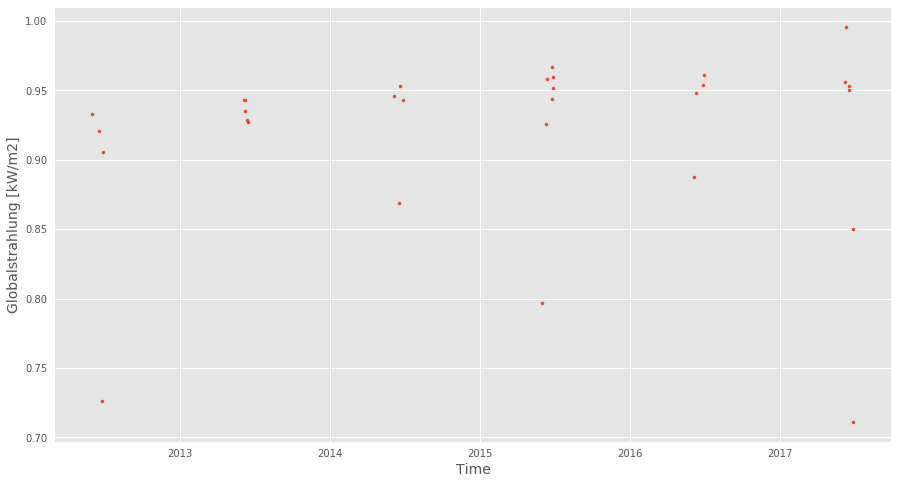

In [141]:
# Time Series Plot
plt.figure(figsize = (15,8))
plt.plot(dfp.index,dfp.globalstrahlung,'.')
plt.ylabel("Globalstrahlung [kW/m2]",size=14)
plt.xlabel("Time",size=14)
plt.show()

In [112]:
# Careful this plot takes a while to render
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #need to use plotly offline

# Sub Datafrem eines bestimmter Zeitperiode Juni 2015
# df_hour_s = df_hour[(df_hour.index >= '2015-06-01-00') & (df_hour.index <= '2015-06-31-23')]

data = Data([Bar(x=dfp.index, y=dfp.ertrag_modul1, name='ertrag_modul1'),
             Bar(x=dfp.index, y=dfp.globalstrahlung, name='globalstrahlung'),
             Bar(x=dfp.index, y=dfp.lufttemperatur/10, name='lufttemperatur /10')])
             
iplot(Figure(data=data, layout= Layout(title='PV Daten von Birchli um 12:20 an Schönentagen in kW')))

In [113]:
dfp.index.year.value_counts()

2013    3
2014    2
2017    2
2016    2
2015    1
2012    1
Name: timestamp, dtype: int64

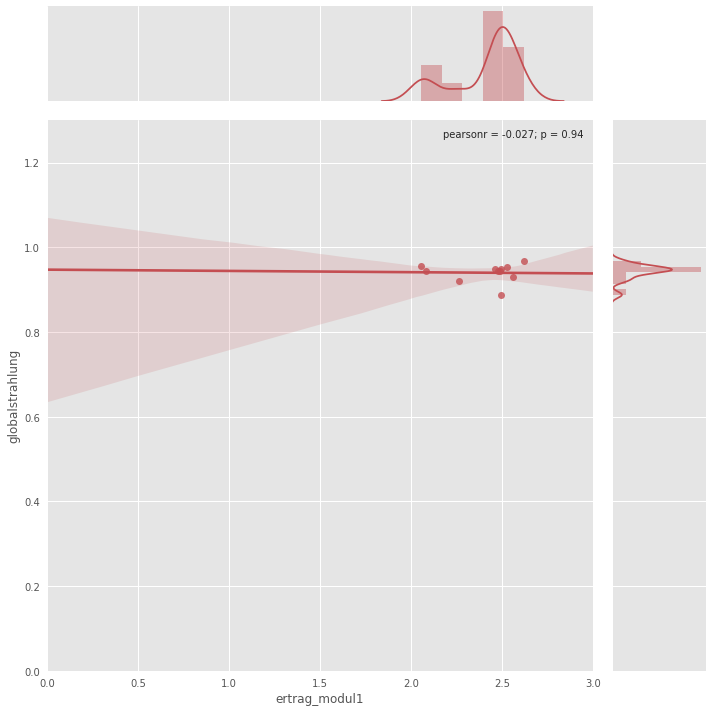

In [114]:
# Lineare Regression with Mariginal distributions
g = sns.jointplot("ertrag_modul1","globalstrahlung", data=dfp, kind="reg",xlim=(0, 3), ylim=(0, 1.3),color="r", size=10)


### Berechne den Systemwirkungsgrad oder auch Performance ratio
PR = Realer Anlageertrag [kWh] / Globalstrahlung [kWh/m2] * Modulfläche [m2] * Modulwirkungsgrad

In [115]:
# Wirkungsgrad Ertrag der 20m2 Anlage / Globalstrahlung in w/m2
# Total über alles
df['systemwirkungsgrad'] = df['ertrag_modul1']/(df['globalstrahlung']*20*0.149)
df.systemwirkungsgrad.describe()

count    1601.000000
mean        1.102867
std         1.136636
min         0.008980
25%         0.721594
50%         0.928565
75%         1.220853
max        26.434293
Name: systemwirkungsgrad, dtype: float64

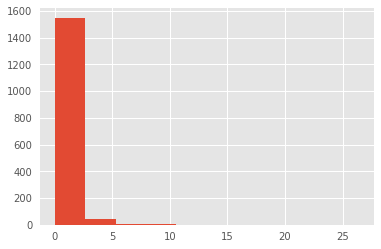

In [116]:
df.systemwirkungsgrad.hist()

In [117]:
# Wirkungsgrad Ertrag der 30m2 Anlage / Globalstrahlung in w/m2
# Monats auswhal
dfp['systemwirkungsgrad'] = dfp['ertrag_modul1']/(dfp['globalstrahlung']*20*0.149)
dfp.systemwirkungsgrad.describe()

count    11.000000
mean      0.861438
std       0.071232
min       0.722389
25%       0.846560
50%       0.883527
75%       0.899674
max       0.943225
Name: systemwirkungsgrad, dtype: float64

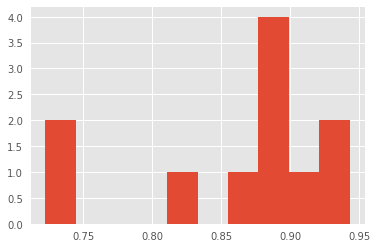

In [118]:
dfp.systemwirkungsgrad.hist()

In [119]:
# Careful this plot takes a while to render
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #need to use plotly offline

# Sub Datafrem eines bestimmter Zeitperiode Juni 2015
# df_hour_s = df_hour[(df_hour.index >= '2015-06-01-00') & (df_hour.index <= '2015-06-31-23')]

data = Data([Bar(x=dfp.index, y=dfp.ertrag_modul1, name='ertrag_modul1'),
             Bar(x=dfp.index, y=dfp.globalstrahlung, name='globalstrahlung'),
             Bar(x=dfp.index, y=dfp.systemwirkungsgrad, name='systemwirkungsgrad'),
             Bar(x=dfp.index, y=dfp.lufttemperatur/10, name='lufttemperatur / 10')])
             
iplot(Figure(data=data, layout= Layout(title='PV Daten von Birchli um 12:20 an Schönentagen in kW')))

### Was passierte in der Woche vom 17 Juni 2017?

In [120]:
# Careful this plot takes a while to render
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #need to use plotly offline

# Sub Datafrem eines bestimmter Zeitperiode Juni 2015
dfs = df[(df.index >= '2017-06-15-00-00') & (df.index <= '2017-06-20-00-00')]

data = Data([Bar(x=dfs.index, y=dfs.ertrag_modul1, name='ertrag_modul1'),
             Bar(x=dfs.index, y=dfs.globalstrahlung, name='globalstrahlung'),
             Bar(x=dfs.index, y=dfs.systemwirkungsgrad, name='systemwirkungsgrad'),
             Bar(x=dfs.index, y=dfs.lufttemperatur/10, name='lufttemperatur / 10')])
             
iplot(Figure(data=data, layout= Layout(title='PV Daten von Birchli um 12:20 an Schönentagen in kW')))

### Fit liniear regression of Wirkungsgrad über die gefilterten Daten
How-To https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

In [121]:
# fit a linear regression
from scipy import stats
x = range(len(dfp)) # just a hack to have a int as x index of dfp can not be used
slope, intercept, r_value, p_value, std_err = stats.linregress(x,dfp.systemwirkungsgrad)
# To get coefficient of determination (r_squared)
print("slope:", slope)
print("intercept:", intercept)
print("r_value:", r_value)
print("p_value:", p_value)
print("r-squared:", r_value**2)
print("std_err:", std_err)

slope: -0.0033218292721129464
intercept: 0.8780472673435933
r_value: -0.1546673933252495
p_value: 0.6497731165514073
r-squared: 0.023922002558027435
std_err: 0.007072933069098444


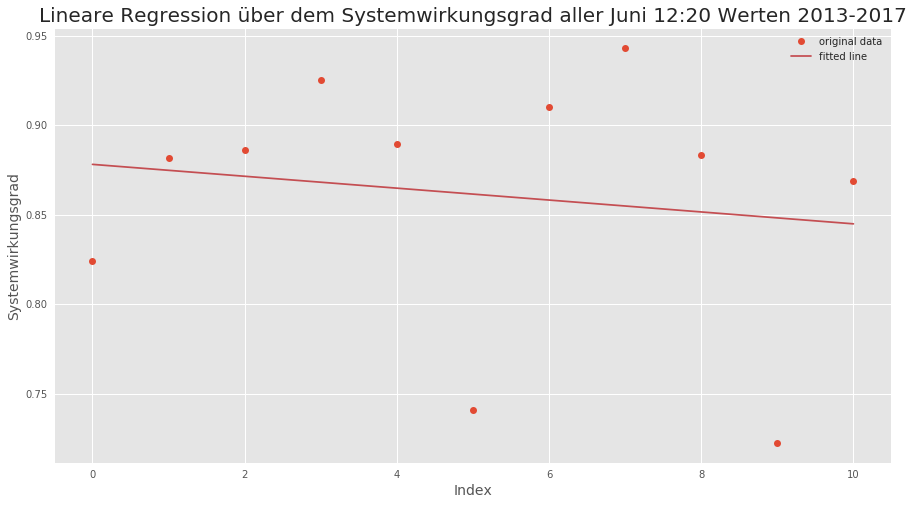

In [122]:
#Plot the data along with the fitted line
plt.figure(figsize = (15,8))
plt.plot(x, dfp.systemwirkungsgrad, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.ylabel("Systemwirkungsgrad",size=14)
plt.xlabel("Index",size=14)
plt.title("Lineare Regression über dem Systemwirkungsgrad aller Juni 12:20 Werten 2013-2017",size=20)
plt.show()

### Fit liniear regression des Systemwirkungsgrad (ungefiltert)

In [137]:
# Systemwirkungsgrad auserhalb 70% und 95% Machen keinen Sinn -> Vergelichbarkeit erhöhen
dff = df[(df.systemwirkungsgrad >= (0.8)) & (df.systemwirkungsgrad <= (1.2))]

# Sehen wir dieser Rückgang auch über zwei Monate?
x = range(len(dff)) # just a hack to have a int as x index of dfp can not be used
slope, intercept, r_value, p_value, std_err = stats.linregress(x,dff.systemwirkungsgrad)
# To get coefficient of determination (r_squared)
print("r-squared:", r_value**2)
print("std_err:", std_err)

r-squared: 0.0003521458996053771
std_err: 1.9785032156648076e-05


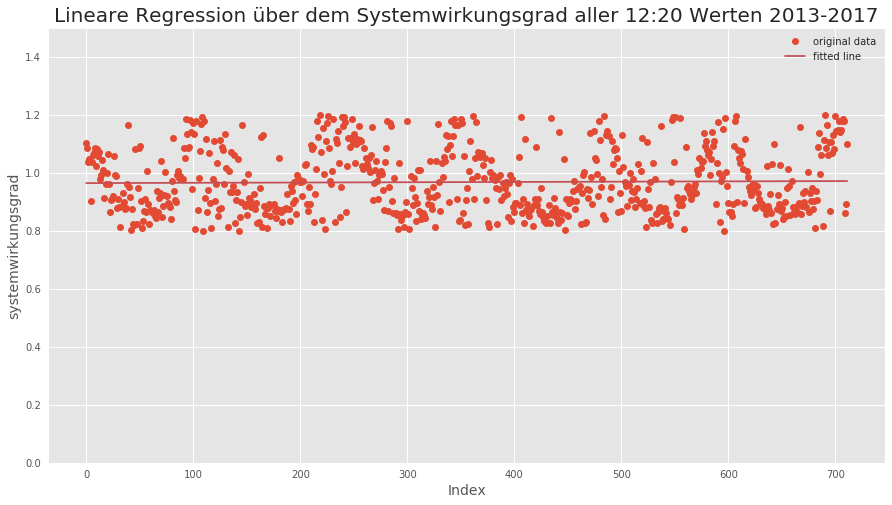

In [138]:
#Plot the data along with the fitted line
plt.figure(figsize = (15,8))
plt.plot(x, dff.systemwirkungsgrad, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.ylim(0,1.5)
plt.ylabel("systemwirkungsgrad",size=14)
plt.xlabel("Index",size=14)
plt.title("Lineare Regression über dem Systemwirkungsgrad aller 12:20 Werten 2013-2017",size=20)
plt.show()

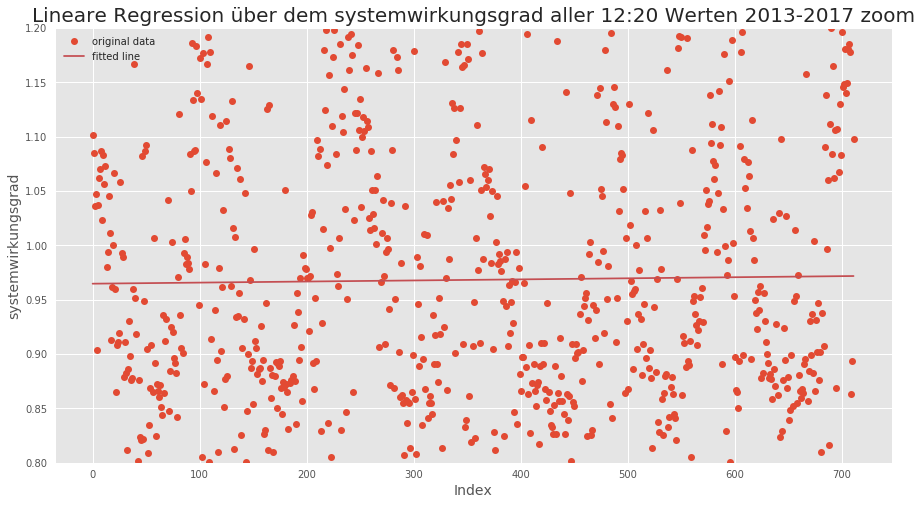

In [139]:
#Zoom
plt.figure(figsize = (15,8))
plt.plot(x, dff.systemwirkungsgrad, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.ylim(0.8,1.2)
plt.ylabel("systemwirkungsgrad",size=14)
plt.xlabel("Index",size=14)
plt.title("Lineare Regression über dem systemwirkungsgrad aller 12:20 Werten 2013-2017 zoom",size=20)
plt.show()

### Was liegt den Ausreiser zu Grunde?

### Was ist zischen 26.06.2015 - 28.06.2015 passiert?


## Tabellen Normalisieren und Agregieren
Zeitraum 01.01.2012 - 31.12.2017

### Monats Dataframes der Wetterdaten und PV Ertragsdaten aggregieren

In [ ]:
df = pd.concat([dfb, dfm], axis=1)
df.head(2)

## Weiteres Vorgehen
Nun sind die daten agregiert in der tabelle df_hour zur verfügung.
### Normalisieren der Werte
TODO: Um graphisch was sehen zu können müssten die Daten zuerst mal normalisiert werden auf 0...100. Wobei 100 die maximale grösse der jeweiligen Parameter ist. Es hat wenig oder viel!
### Random Forest ausprobieren
Nun sind die daten agregiert in der tabelle df_hour zur verfügung.
Viele Beispiele im Netz

# Random Forest
Zur vorhersage der PV Ertragsdaten wird der Randomforest Algorithmuss verwendet.

## Trainings und Testdaten
Der Komplete Datensatz wird unterteilt in Trainings und Testdaten
